In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 5
mlp.rcParams['xtick.major.size'] = 20
mlp.rcParams['xtick.major.width'] = 5
mlp.rcParams['xtick.labelsize'] = 20
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 20
mlp.rcParams['ytick.major.width'] = 5
mlp.rcParams['ytick.labelsize'] = 20
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sqlalchemy import create_engine

# Установка соединения с базой данных
conn_uri = "SQLALCHEMY_DATABASE_URL"
engine = create_engine(conn_uri)

In [4]:
post_text = pd.read_sql("SELECT * FROM public.post_text_df;", conn_uri)
post_text.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [5]:
### Посмотрим на категориальные колонки
post_text.describe(include='object')

,text,topic
count,7023,7023
unique,6924,7
top,Microsoft gets the blogging bug\n\nSoftware gi...,movie
freq,2,3000


In [6]:
### Посмотрим на вещественные колонки
post_text.describe()

,post_id
count,7023.000000
mean,3666.533817
std,2109.613383
min,1.000000
25%,1849.500000
50%,3668.000000
75%,5492.000000
max,7319.000000


In [7]:
### Сделаем эмбеддинги постов 

from transformers import AutoTokenizer
from transformers import BertModel  # https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel
from transformers import RobertaModel  # https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaModel
from transformers import DistilBertModel  # https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertModel


def get_model(model_name):
    assert model_name in ['bert', 'roberta', 'distilbert']

    checkpoint_names = {
        'bert': 'bert-base-cased',  # https://huggingface.co/bert-base-cased
        'roberta': 'roberta-base',  # https://huggingface.co/roberta-base
        'distilbert': 'distilbert-base-cased'  # https://huggingface.co/distilbert-base-cased
    }

    model_classes = {
        'bert': BertModel,
        'roberta': RobertaModel,
        'distilbert': DistilBertModel
    }

    return AutoTokenizer.from_pretrained(checkpoint_names[model_name]), model_classes[model_name].from_pretrained(checkpoint_names[model_name])

In [8]:
tokenizer, model = get_model('distilbert')

In [9]:
### Сделаем датасет для постов

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding


class PostDataset(Dataset):
    def __init__(self, texts, tokenizer):
        super().__init__()

        self.texts = tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_tensors='pt',
            truncation=True,
            padding=True
        )
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        return {'input_ids': self.texts['input_ids'][idx], 'attention_mask': self.texts['attention_mask'][idx]}

    def __len__(self):
        return len(self.texts['input_ids'])
    
    
dataset = PostDataset(post_text['text'].values.tolist(), tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loader = DataLoader(dataset, batch_size=32, collate_fn=data_collator, pin_memory=True, shuffle=False)

In [10]:
import torch
from tqdm import tqdm


@torch.inference_mode()
def get_embeddings_labels(model, loader):
    model.eval()
    
    total_embeddings = []
    
    for batch in tqdm(loader):
        batch = {key: batch[key].to(device) for key in ['attention_mask', 'input_ids']}

        embeddings = model(**batch)['last_hidden_state'][:, 0, :]

        total_embeddings.append(embeddings.cpu())

    return torch.cat(total_embeddings, dim=0)

In [11]:
device = torch.device('cpu')

model = model.to(device)

In [12]:
embeddings = get_embeddings_labels(model, loader).numpy()

embeddings

100%|██████████| 220/220 [30:07<00:00,  8.22s/it]


array([[ 3.63151133e-01,  4.89374585e-02, -2.64081091e-01, ...,
        -1.41593426e-01,  1.59183219e-02,  9.20901075e-05],
       [ 2.36416310e-01, -1.59501255e-01, -3.27798098e-01, ...,
        -2.89936274e-01,  1.19365379e-01, -1.62361329e-03],
       [ 3.75191599e-01, -1.13943964e-01, -2.40546912e-01, ...,
        -3.38918984e-01,  5.86940944e-02, -2.12654732e-02],
       ...,
       [ 3.40382487e-01,  6.64923936e-02, -1.63184404e-01, ...,
        -8.65628272e-02,  2.03403547e-01,  3.20906341e-02],
       [ 4.32092339e-01,  1.10913441e-02, -1.17306113e-01, ...,
         7.54016861e-02,  1.02739736e-01,  1.52742937e-02],
       [ 3.04277718e-01, -7.62157291e-02, -6.77586868e-02, ...,
        -5.43488525e-02,  2.44383499e-01, -1.41482204e-02]], dtype=float32)

In [13]:
### Пытаемся кластеризовать тексты

from sklearn.decomposition import PCA

centered = embeddings - embeddings.mean()

pca = PCA(n_components=50)
pca_decomp = pca.fit_transform(centered)

In [14]:
from sklearn.cluster import KMeans

n_clusters = 20

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pca_decomp)

post_text['TextCluster'] = kmeans.labels_

dists_columns = [f'DistanceToCluster_{i}' for i in range(n_clusters)]

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,DistanceToCluster_3,DistanceToCluster_4,DistanceToCluster_5,DistanceToCluster_6,DistanceToCluster_7,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,DistanceToCluster_15,DistanceToCluster_16,DistanceToCluster_17,DistanceToCluster_18,DistanceToCluster_19
0,2.336141,3.438395,3.468229,2.834352,3.585387,3.580357,3.367754,3.500286,1.982536,2.218843,3.474113,2.944754,3.423517,3.224678,3.430600,3.289100,4.091984,3.407392,3.760073,1.763749
1,2.313666,3.494698,3.387631,2.557229,3.419855,3.278313,3.081223,3.178010,2.200136,2.237159,3.251419,2.811498,3.315385,2.753095,3.317074,3.225322,3.682405,3.204949,3.558242,1.421731
2,2.386404,3.583815,3.434359,2.890392,3.486081,3.275091,3.199125,3.160254,1.805973,3.036744,3.396276,3.043356,3.324266,2.956224,3.412703,2.996157,3.384833,3.246879,3.570079,1.710402
3,2.805649,3.778003,3.658119,3.380451,3.703236,3.826407,3.595613,3.859191,2.432657,3.393847,4.068181,3.273676,3.741325,3.584562,3.799882,3.248062,4.226051,3.659238,2.961898,2.462007
4,2.019966,2.911711,3.079805,2.149511,3.151063,2.942884,2.612688,2.875440,1.467113,2.931923,3.244653,2.636332,2.820876,2.508117,2.801484,2.993378,3.265353,2.852379,3.349103,2.121447


In [15]:
post_text = pd.concat((post_text, dists_df), axis=1)
post_text['text_length'] = post_text['text'].apply(len)
post_text = post_text.drop('text', axis=1)
post_text

,post_id,topic,TextCluster,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,DistanceToCluster_3,DistanceToCluster_4,DistanceToCluster_5,DistanceToCluster_6,...,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,DistanceToCluster_15,DistanceToCluster_16,DistanceToCluster_17,DistanceToCluster_18,DistanceToCluster_19,text_length
0,1,business,19,2.336141,3.438395,3.468229,2.834352,3.585387,3.580357,3.367754,...,2.944754,3.423517,3.224678,3.430600,3.289100,4.091984,3.407392,3.760073,1.763749,1967
1,2,business,19,2.313666,3.494698,3.387631,2.557229,3.419855,3.278313,3.081223,...,2.811498,3.315385,2.753095,3.317074,3.225322,3.682405,3.204949,3.558242,1.421731,2701
2,3,business,19,2.386404,3.583815,3.434359,2.890392,3.486081,3.275091,3.199125,...,3.043356,3.324266,2.956224,3.412703,2.996157,3.384833,3.246879,3.570079,1.710402,3408
3,4,business,8,2.805649,3.778003,3.658119,3.380451,3.703236,3.826407,3.595613,...,3.273676,3.741325,3.584562,3.799882,3.248062,4.226051,3.659238,2.961898,2.462007,1026
4,5,business,8,2.019966,2.911711,3.079805,2.149511,3.151063,2.942884,2.612688,...,2.636332,2.820876,2.508117,2.801484,2.993378,3.265353,2.852379,3.349103,2.121447,889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,movie,12,2.747704,1.730912,3.156620,2.350434,3.231735,2.737350,1.806671,...,2.849583,1.241027,2.982934,1.794572,3.111217,3.561427,2.164500,2.440596,3.036307,803
7019,7316,movie,12,2.460658,1.189915,2.941994,2.251594,2.884965,2.394886,1.554680,...,2.535622,0.969309,3.108406,1.752204,2.923199,3.715537,1.921756,2.316256,3.044727,800
7020,7317,movie,12,2.818715,1.961849,2.913198,2.461830,2.747013,2.176114,2.002590,...,2.579862,1.415107,3.069642,1.999537,2.723163,3.674225,2.333149,2.729944,3.295671,636
7021,7318,movie,1,3.006797,1.128040,3.463939,2.329564,3.546819,3.121474,1.583385,...,3.123826,1.588548,3.167659,1.162406,3.389418,3.685771,2.044377,2.105558,3.318633,728


In [16]:
model.cpu()

del model
del tokenizer

del dataset
del loader

del embeddings
del centered
del pca
del pca_decomp

In [17]:
import gc

gc.collect()

5

In [18]:
### Извлечение данных с таргетом 1 и 0 с соотношением 2:1
query_positive_target = """
WITH sampled_feed AS (
    SELECT *
    FROM public.feed_data
    WHERE target = 1
    ORDER BY RANDOM()
    LIMIT 2500000
)
SELECT *
FROM sampled_feed
"""

query_negative_target = """
WITH sampled_feed AS (
    SELECT *
    FROM public.feed_data
    WHERE target = 0
    ORDER BY RANDOM()
    LIMIT 1250000
)
SELECT *
FROM sampled_feed
"""

data_positive = pd.read_sql(query_positive_target, engine)
data_negative = pd.read_sql(query_negative_target, engine)

feed_data = pd.concat([data_positive, data_negative], ignore_index=True)
feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-11-11 10:17:07,71511,1789,view,1
1,2021-11-09 09:31:40,141155,1709,view,1
2,2021-12-16 17:33:56,111453,1316,view,1
3,2021-11-03 17:49:25,57529,690,view,1
4,2021-12-27 21:33:36,128918,3055,view,1


In [19]:
user_data = pd.read_sql("SELECT * FROM public.user_data;", conn_uri)
user_data.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [20]:
data = pd.merge(feed_data, user_data, on='user_id', how='left')

In [21]:
del feed_data
del user_data

In [22]:
import gc

gc.collect()

124

In [23]:
### Посмотрим на категориальные колонки
data.describe(include = 'object')

,action,country,city,os,source
count,3750000,3750000,3750000,3750000,3750000
unique,2,11,3915,2,2
top,view,Russia,Moscow,Android,ads
freq,3601349,3161122,599190,2431681,2336930


In [24]:
### Посмотрим на вещественные колонки
data.describe()

,user_id,post_id,target,gender,age,exp_group
count,3.750000e+06,3.750000e+06,3.750000e+06,3.750000e+06,3.750000e+06,3.750000e+06
mean,8.504540e+04,3.408848e+03,6.666667e-01,5.763549e-01,2.719368e+01,1.972822e+00
std,4.898397e+04,2.097436e+03,4.714046e-01,4.941356e-01,1.022872e+01,1.362687e+00
min,2.000000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.400000e+01,0.000000e+00
25%,4.098300e+04,1.533000e+03,0.000000e+00,0.000000e+00,1.900000e+01,1.000000e+00
50%,8.545800e+04,3.219000e+03,1.000000e+00,1.000000e+00,2.400000e+01,2.000000e+00
75%,1.277210e+05,5.228000e+03,1.000000e+00,1.000000e+00,3.300000e+01,3.000000e+00
max,1.685520e+05,7.319000e+03,1.000000e+00,1.000000e+00,9.500000e+01,4.000000e+00


In [25]:
### Обработка временных данных и сортировка
data['timestamp'] = pd.to_datetime(data['timestamp'])

data = data.sort_values(by=['user_id', 'timestamp'], ascending=[True, True])

data['hour'] = data.timestamp.dt.hour
data['month'] = data.timestamp.dt.month
data['day_of_week'] = data.timestamp.dt.dayofweek
data['day'] = data.timestamp.dt.day

In [26]:
### Дополнительные признаки
data['post_likes'] = data.groupby('post_id')['target'].transform('sum')

data = data.fillna(0)

data = data.drop('action', axis = 1)

In [27]:
### Объединение с датафреймом post_text

data = pd.merge(data, post_text, on='post_id', how='left')
data.head()

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,os,...,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,DistanceToCluster_15,DistanceToCluster_16,DistanceToCluster_17,DistanceToCluster_18,DistanceToCluster_19,text_length
0,2021-10-02 14:06:04,200,3146,0,1,34,Russia,Degtyarsk,3,Android,...,1.536087,3.070145,3.344350,3.297258,2.287106,4.180537,3.282031,3.238580,2.588535,140
1,2021-10-02 14:09:27,200,6635,1,1,34,Russia,Degtyarsk,3,Android,...,2.772576,1.647115,3.145356,2.207700,3.032217,3.749222,2.446134,2.281046,3.271626,483
2,2021-10-06 15:02:13,200,668,1,1,34,Russia,Degtyarsk,3,Android,...,2.968009,1.983850,2.724666,1.911275,3.046561,3.315398,2.119372,2.261013,2.697747,2581
3,2021-10-07 20:24:58,200,6578,1,1,34,Russia,Degtyarsk,3,Android,...,2.983869,1.745763,3.507599,2.327002,3.224195,3.872458,2.255754,2.134415,3.426278,717
4,2021-10-07 20:57:00,200,1474,1,1,34,Russia,Degtyarsk,3,Android,...,3.681416,3.471213,2.945859,3.440753,3.865437,3.365990,3.707081,3.952207,3.471257,1065


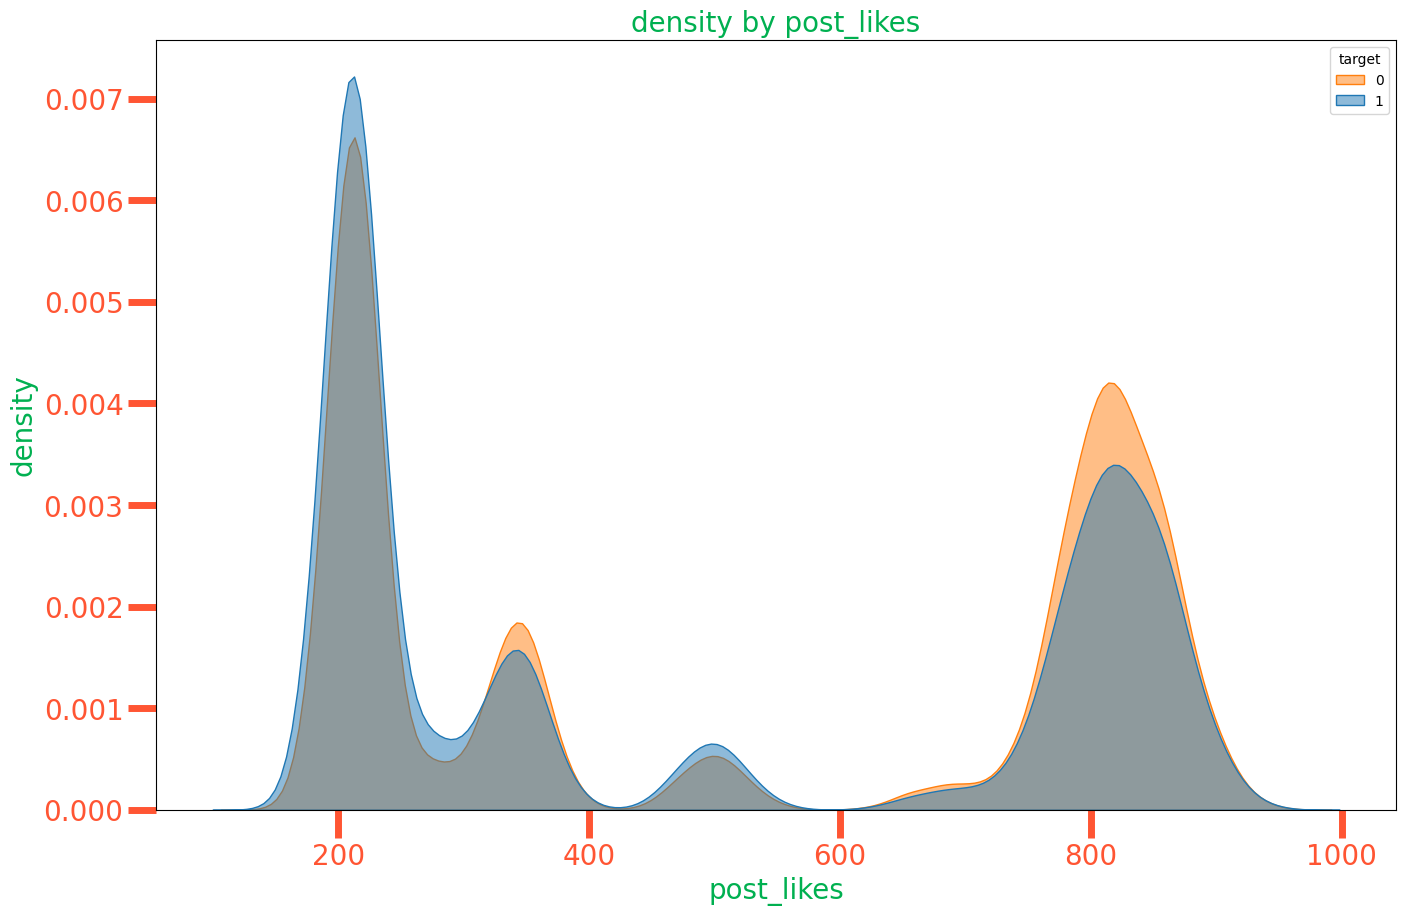

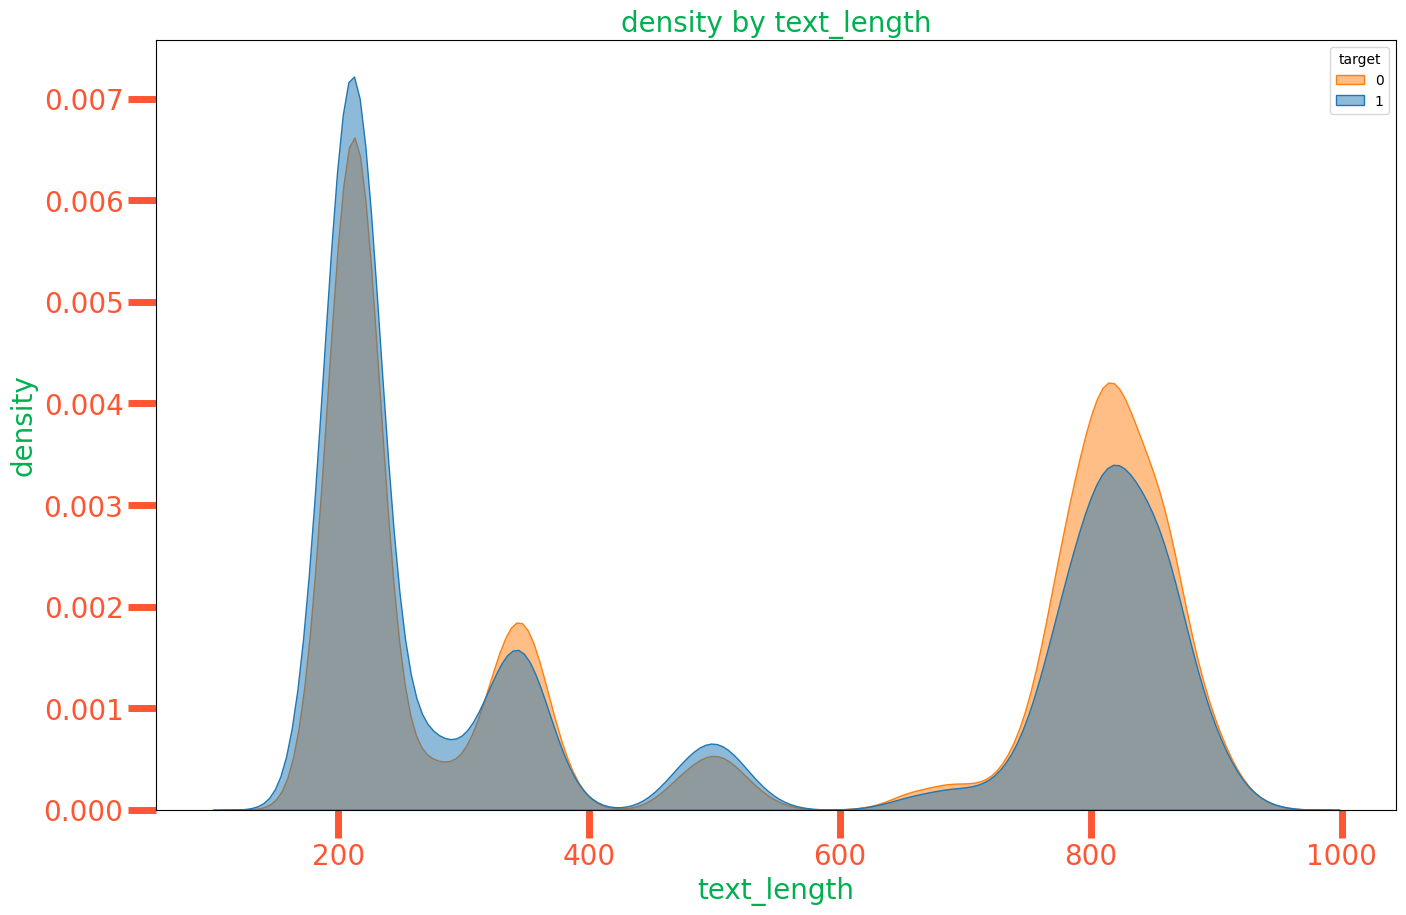

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

### Построение графика плотности

columns = ['post_likes','text_length']

for column in columns:
    plt.figure(figsize=(16, 10))
    sns.kdeplot(data=data, x='post_likes', hue='target', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'density by {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('density')
    plt.legend(title='target', loc='upper right', labels=['0', '1'])
    plt.show()

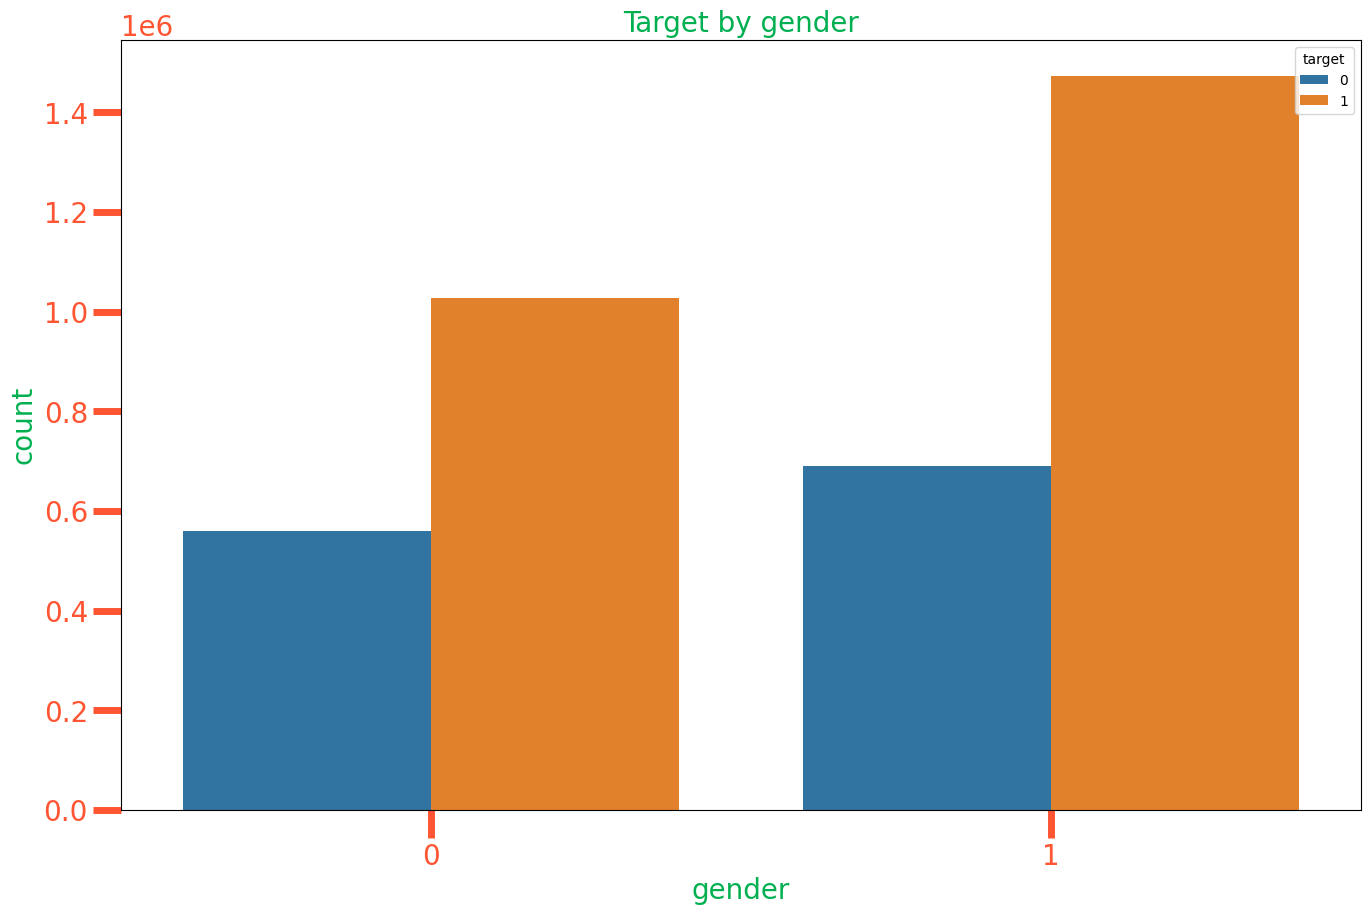

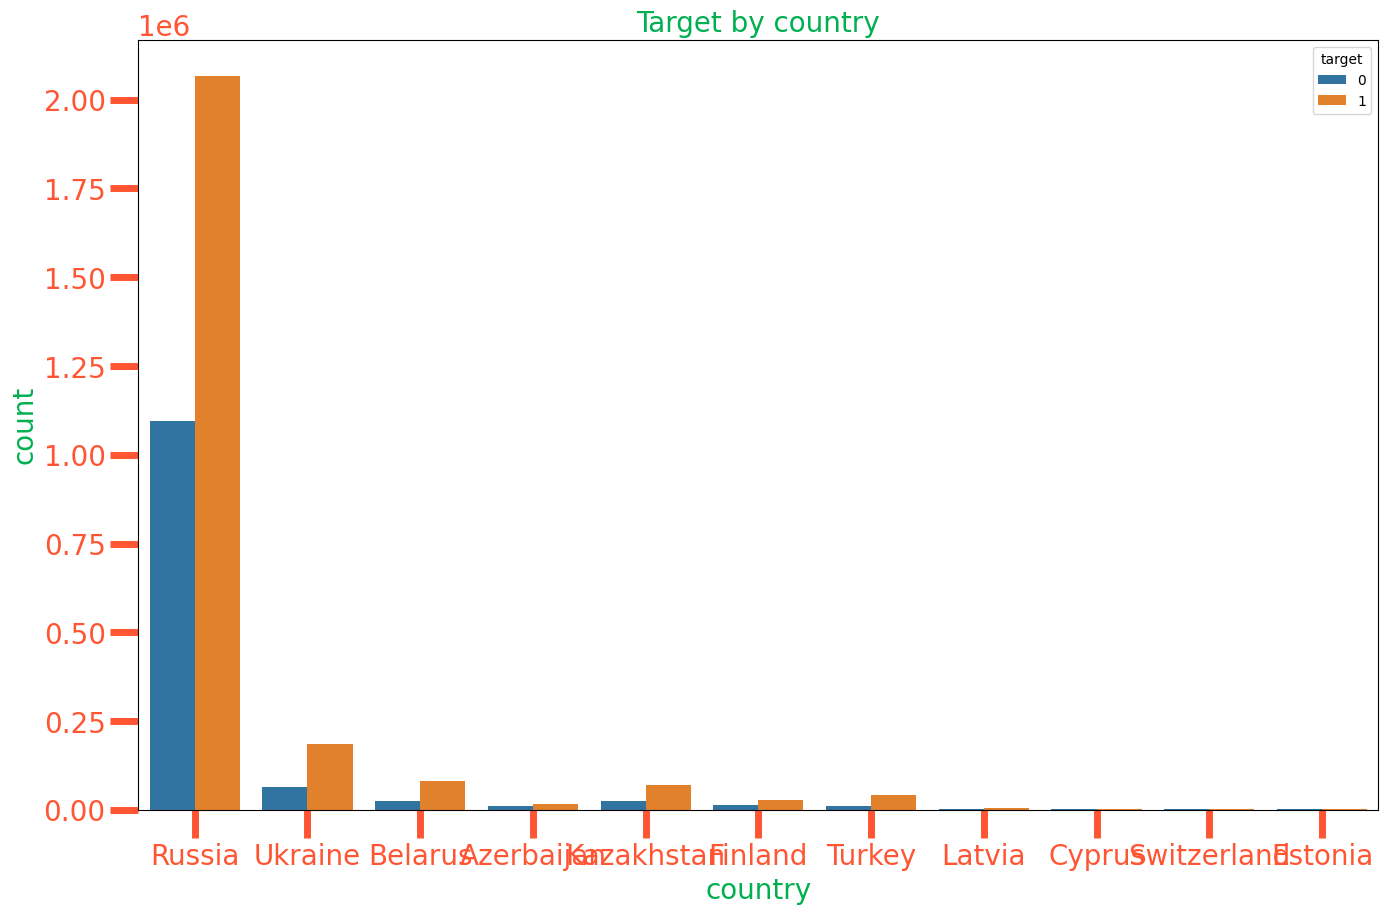

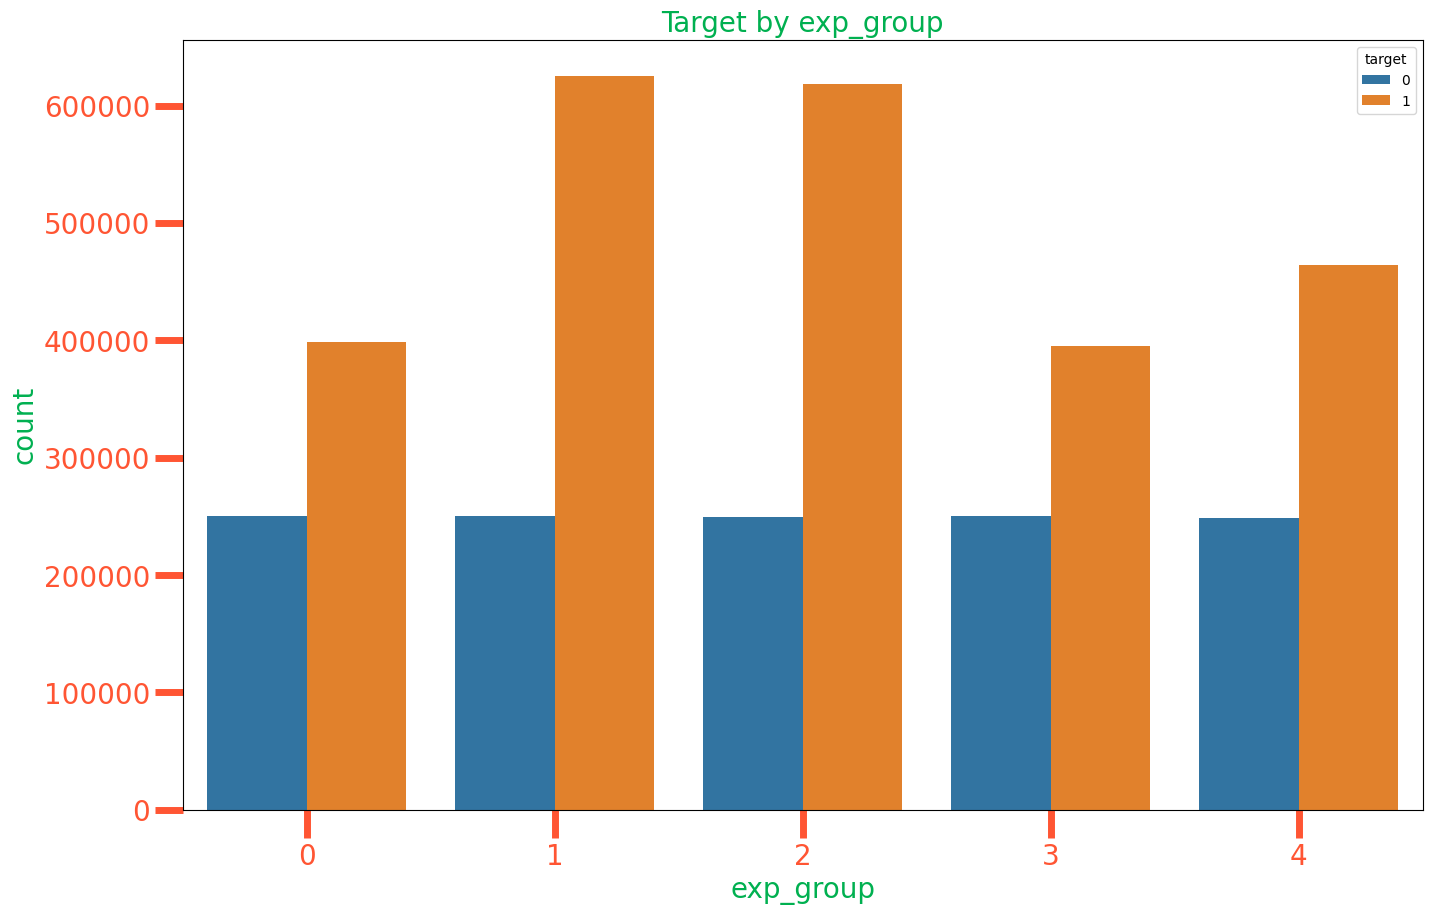

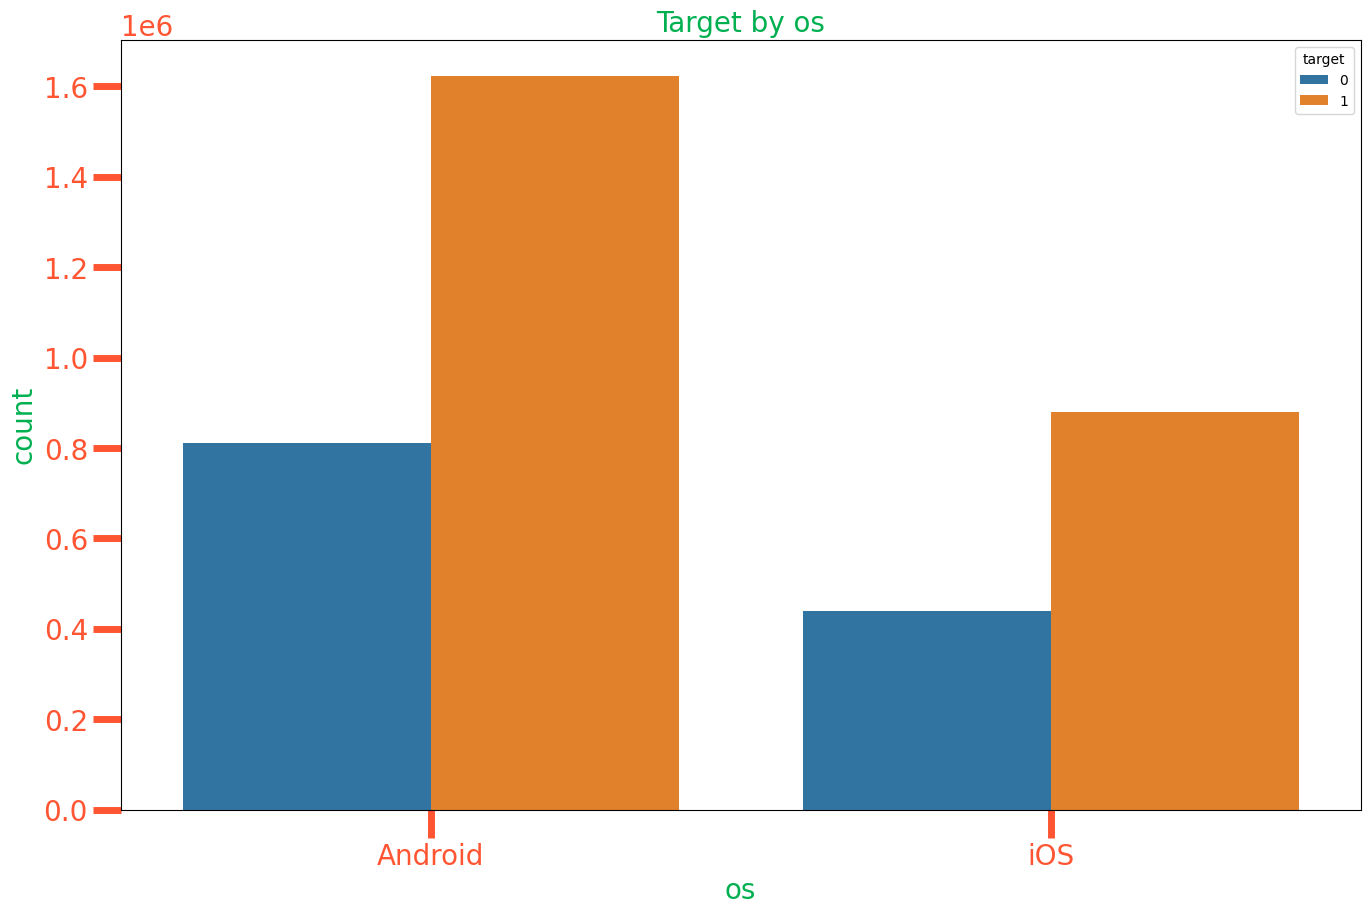

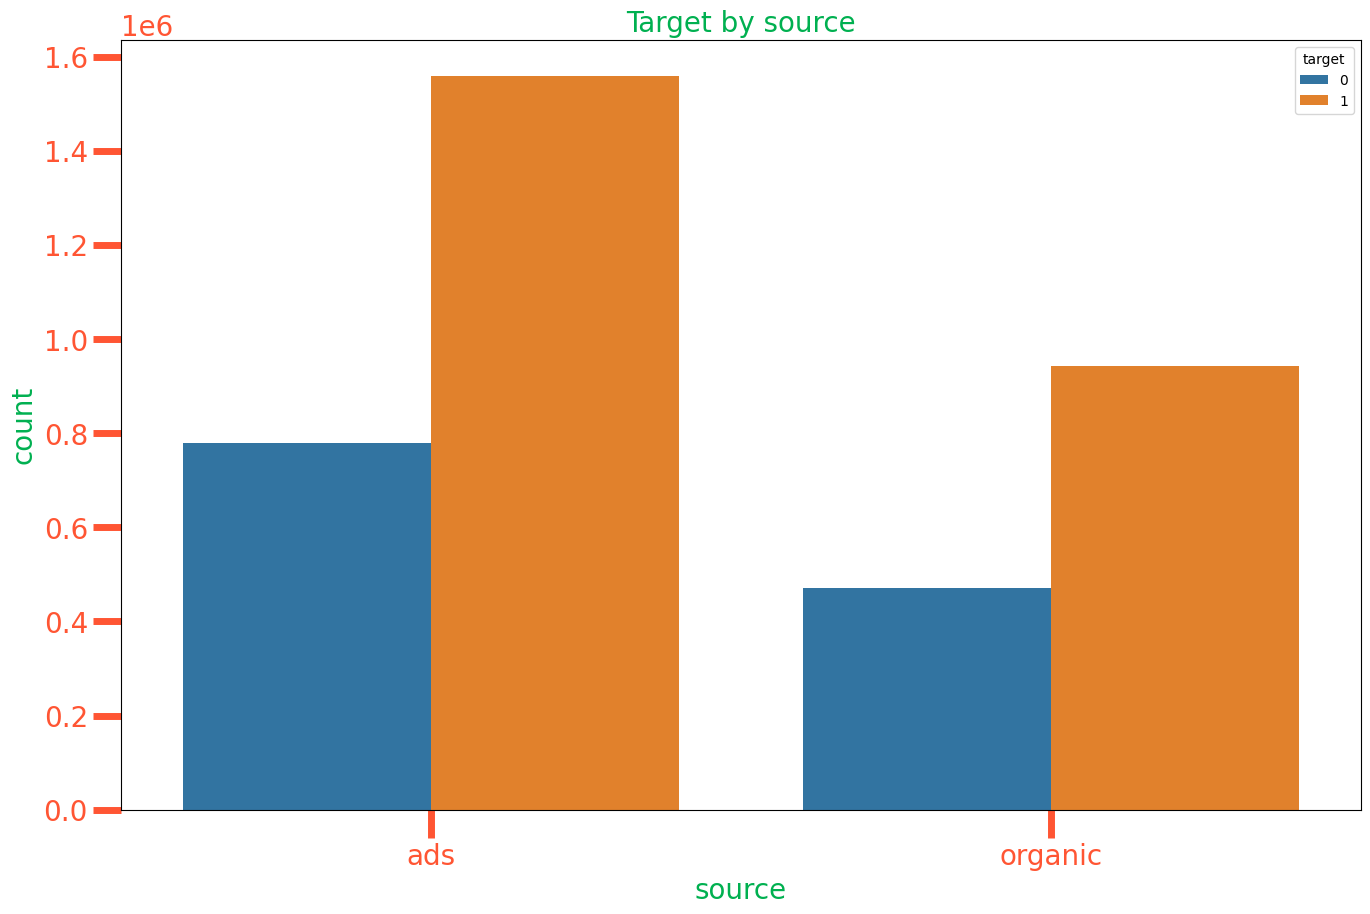

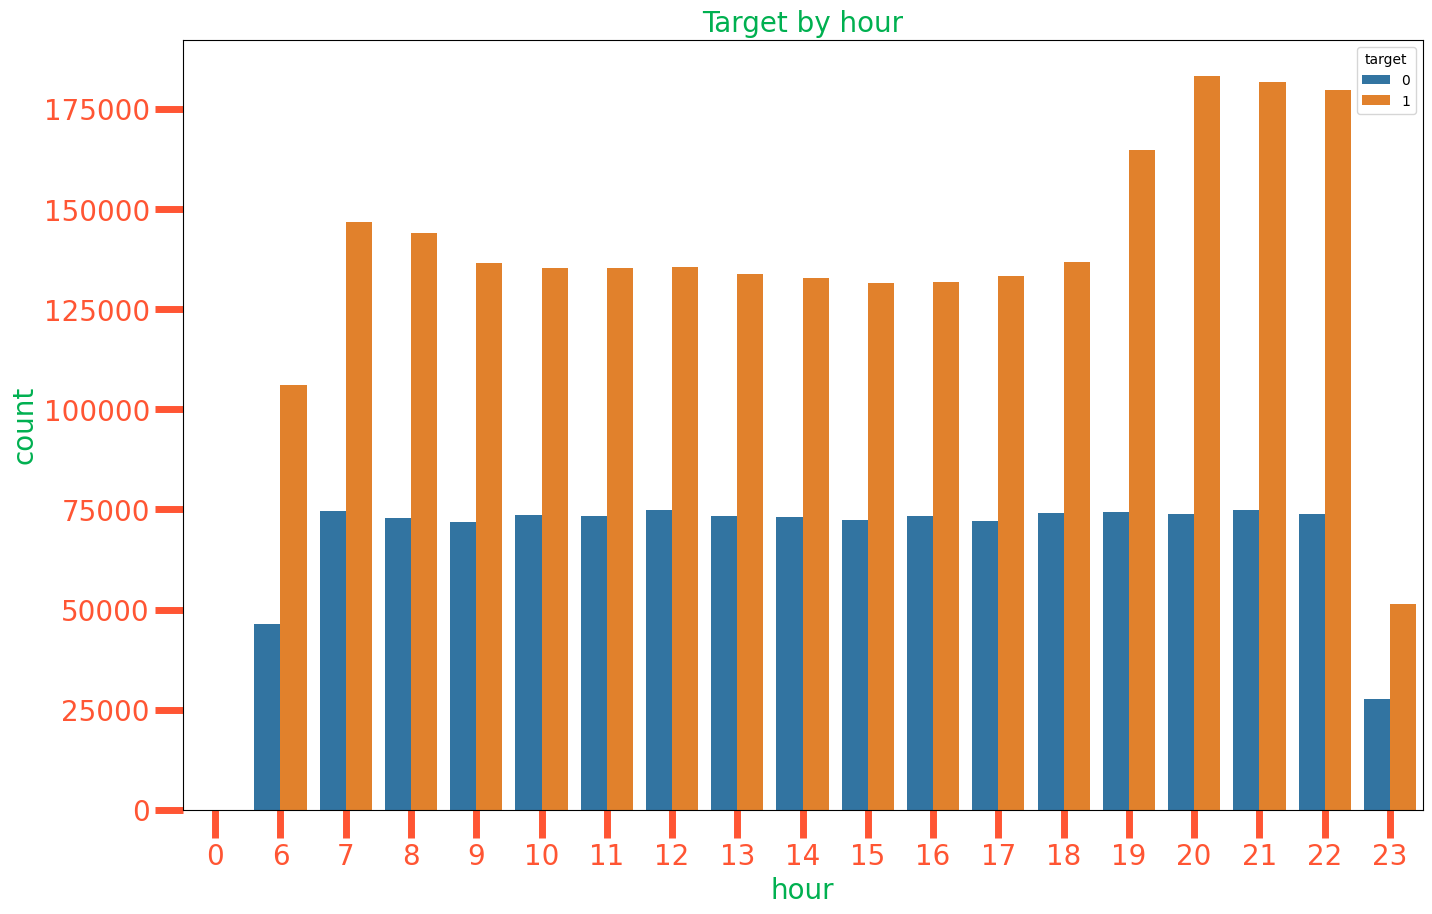

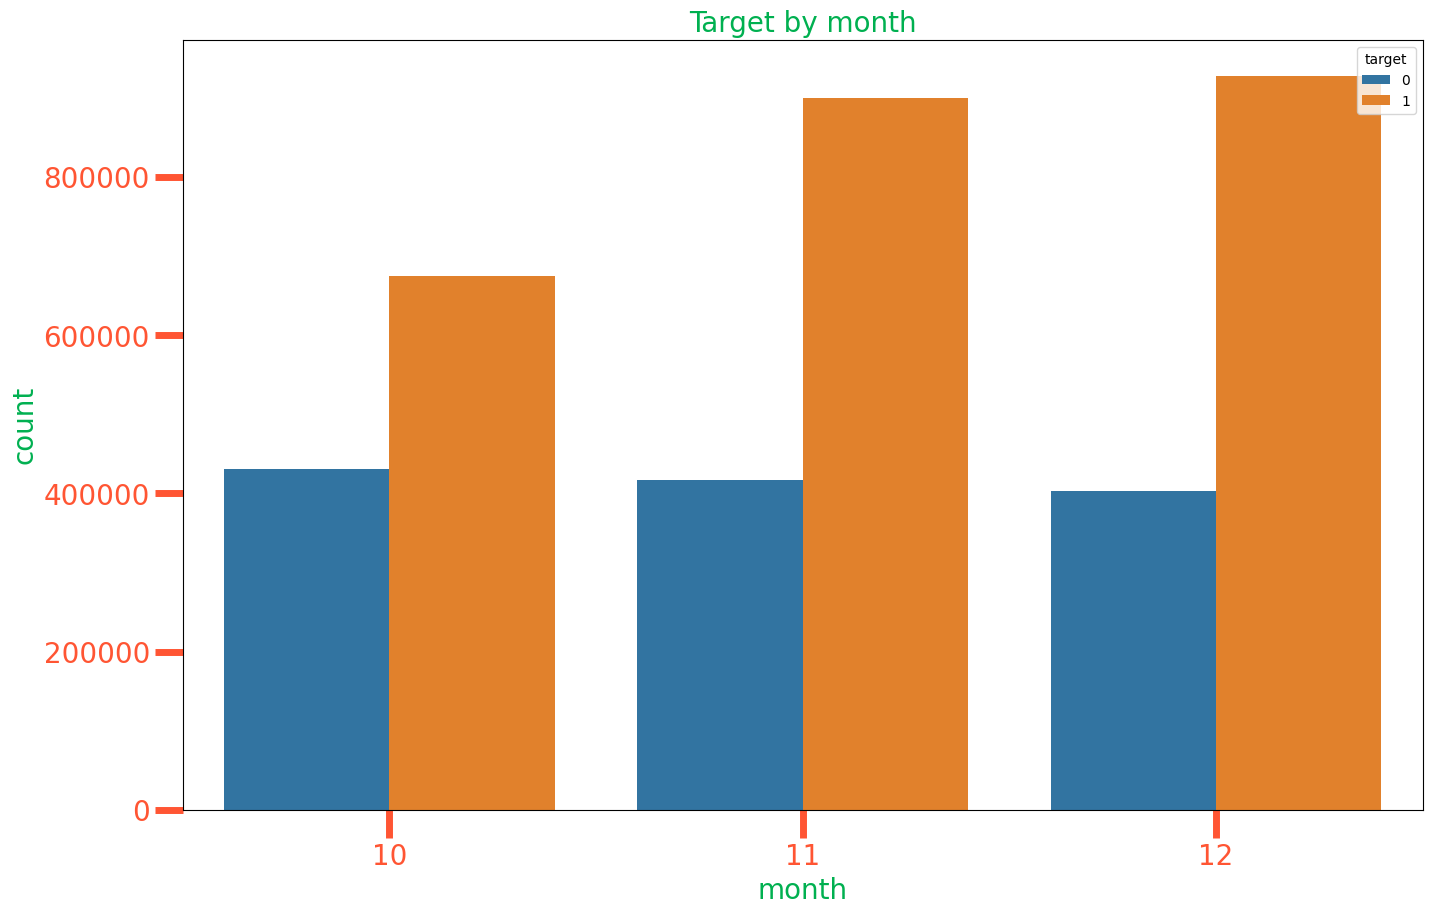

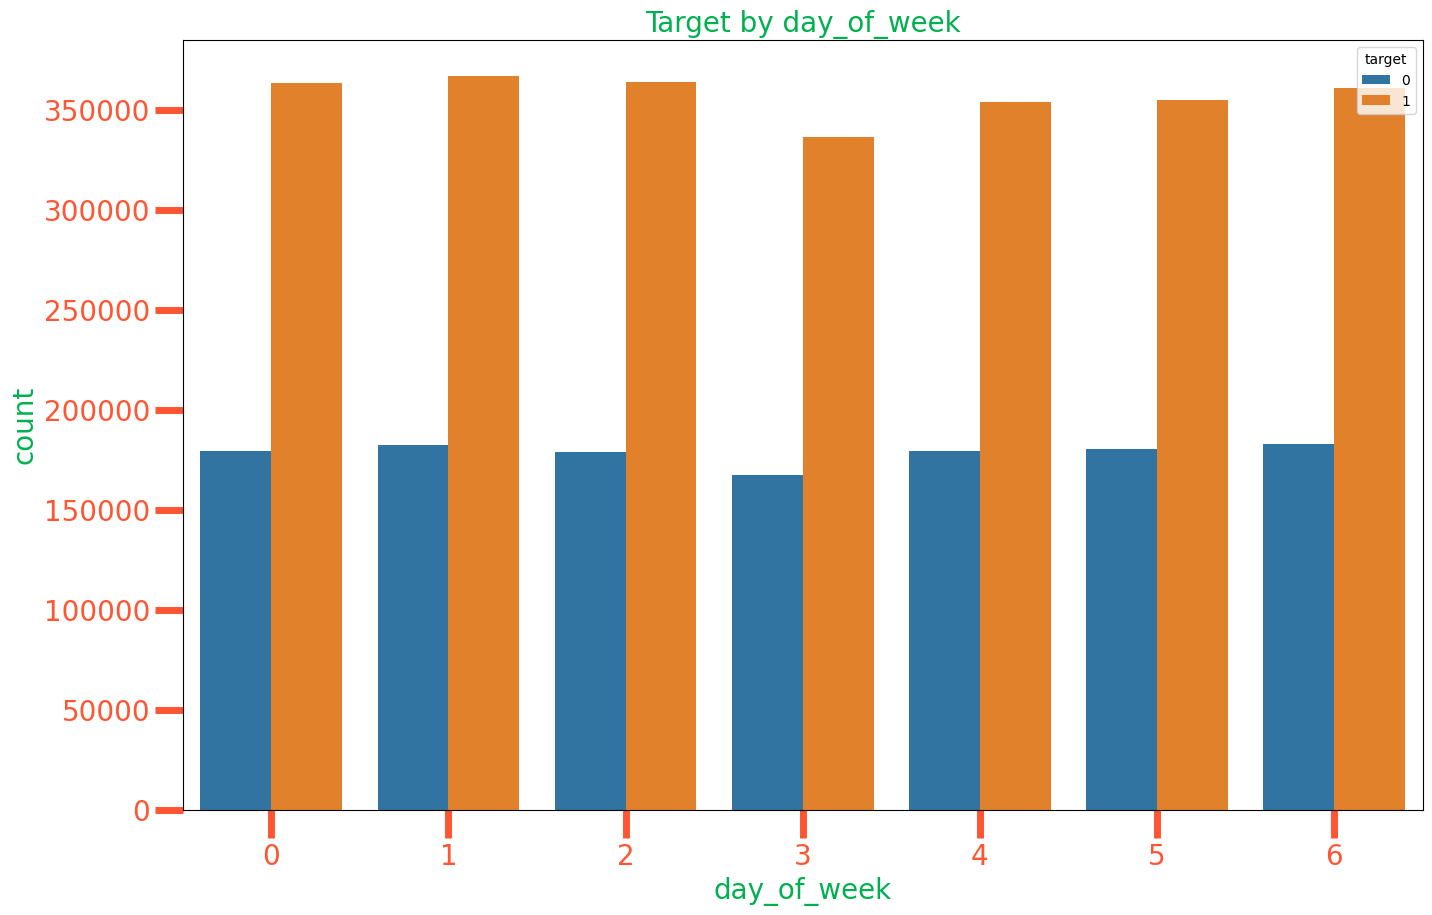

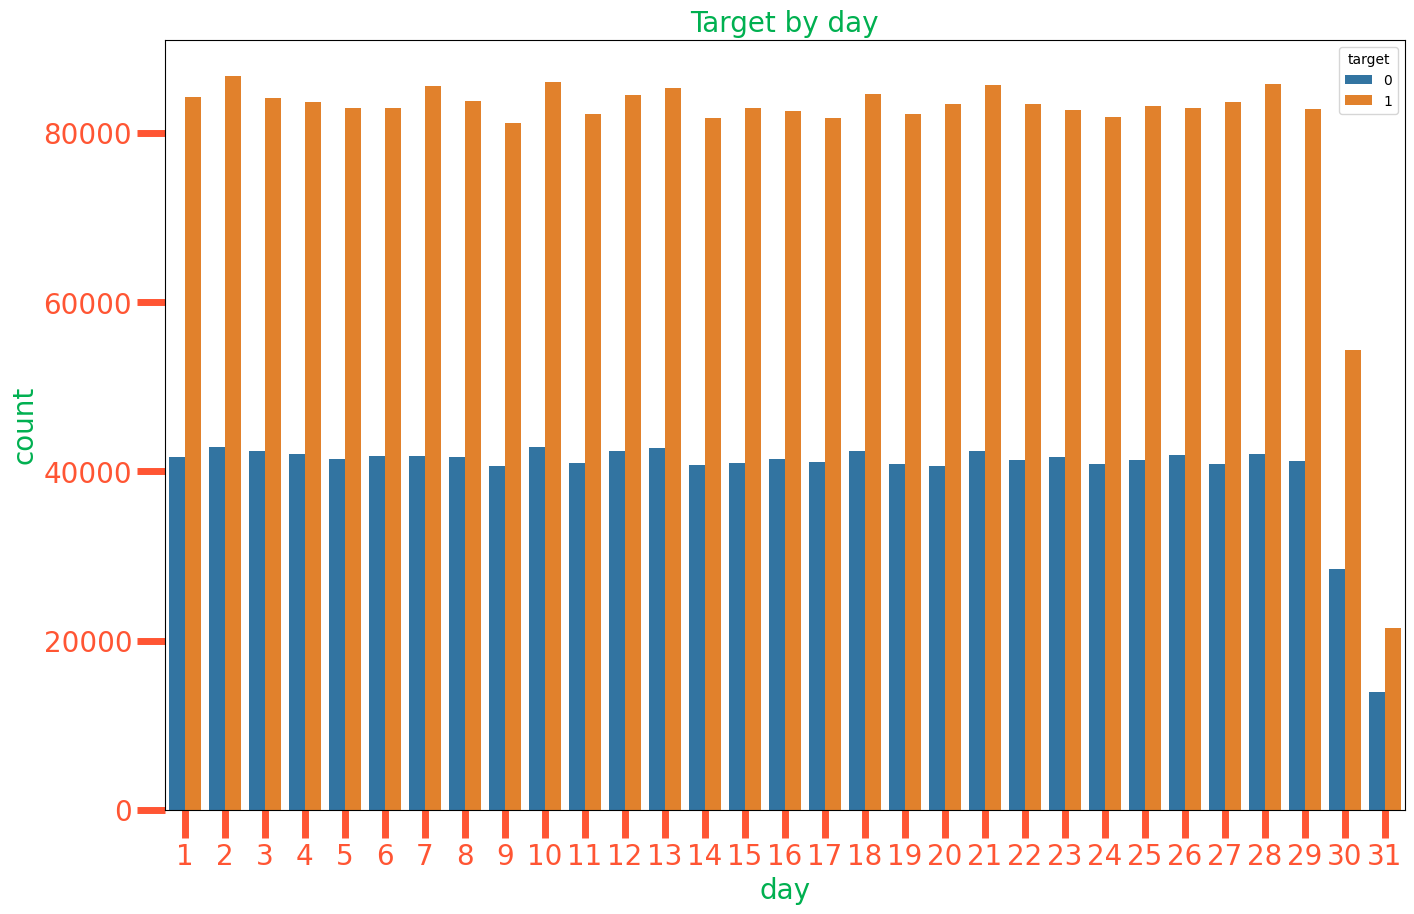

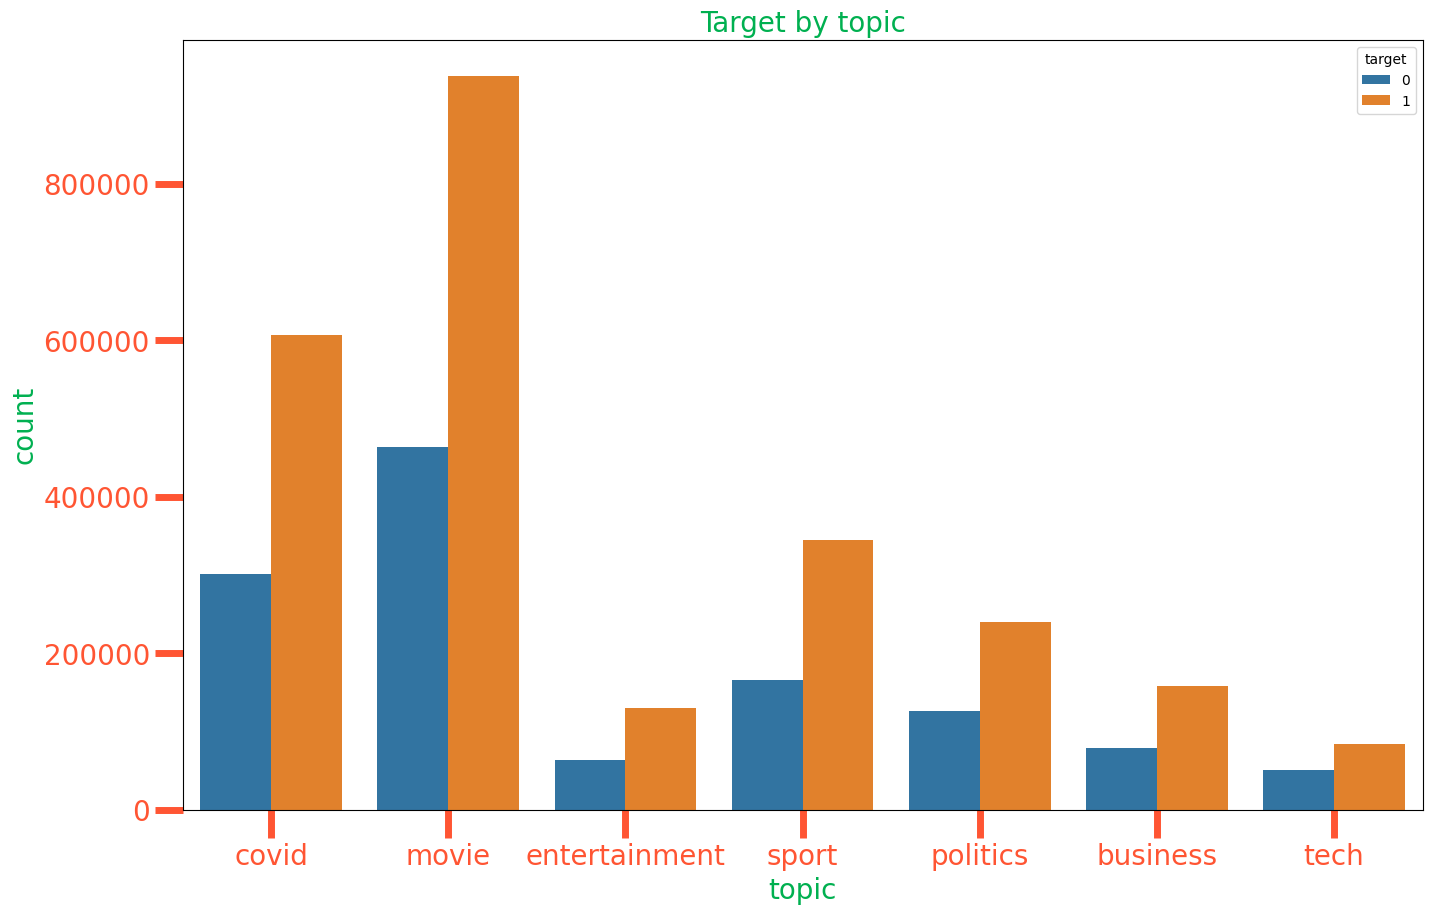

In [29]:
### Построение гистограмм

import matplotlib.pyplot as plt
import seaborn as sns

columns = ['gender', 'country', 'exp_group', 'os', 'source', 'hour', 'month', 'day_of_week', 'day', 'topic']

for column in columns:
    plt.figure(figsize=(16, 10))
    sns.countplot(x=column, hue='target', data=data)
    plt.title(f'Target by {column}')
    plt.ylabel(f'count')
    plt.xlabel(column)
    plt.legend(title='target', loc='upper right', labels=['0', '1'])
    plt.show()


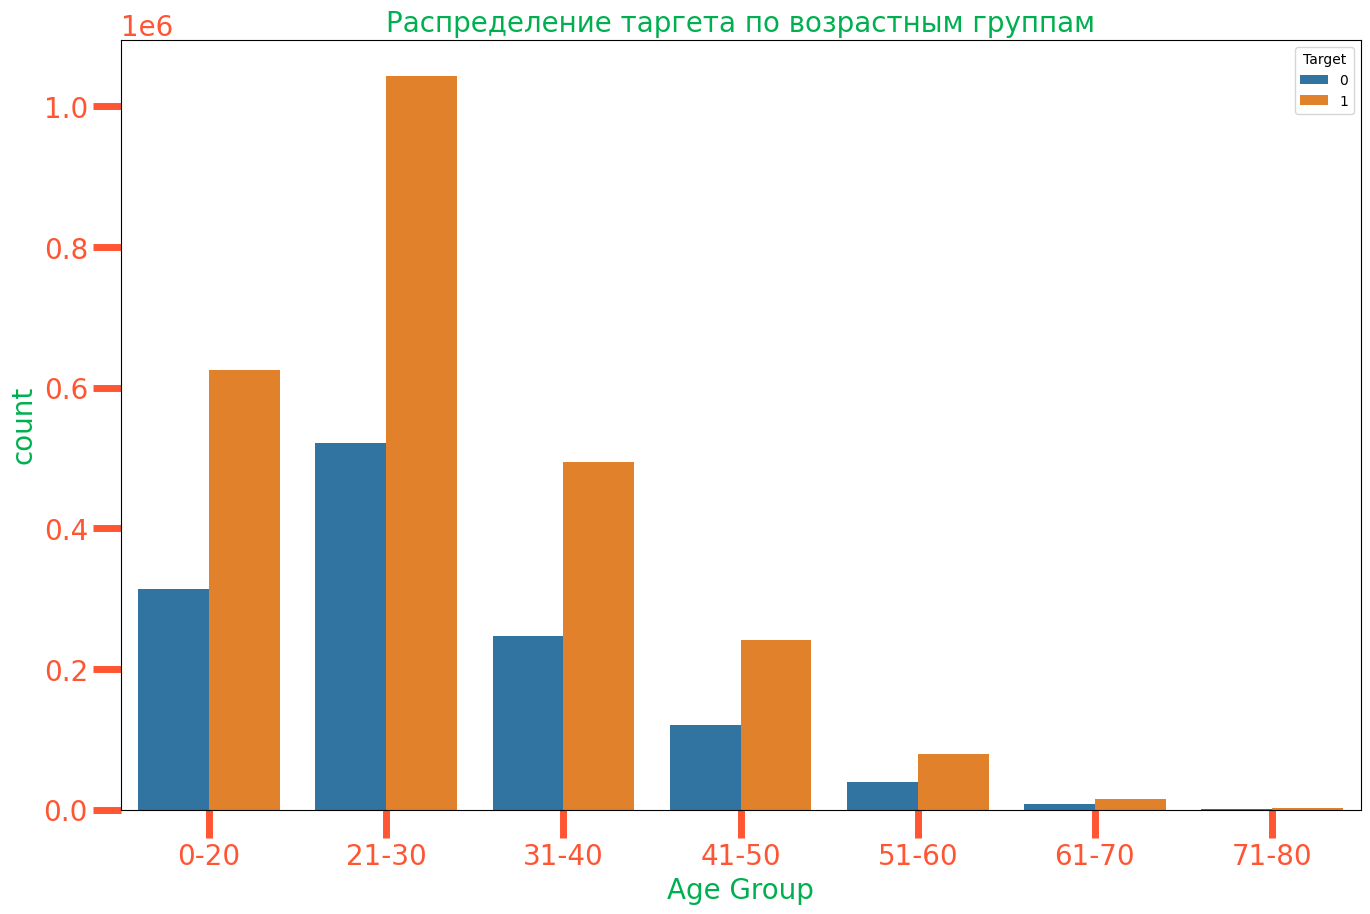

In [30]:
bins = [0, 20, 30, 40, 50, 60, 70, 80]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']

data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

# Построение графика
plt.figure(figsize=(16, 10))
sns.countplot(x='age_group', hue='target', data=data)
plt.title('Распределение таргета по возрастным группам')
plt.ylabel('count')
plt.xlabel('Age Group')
plt.legend(title='Target', loc='upper right', labels=['0', '1'])
plt.show()

data = data.drop('age_group', axis=1)

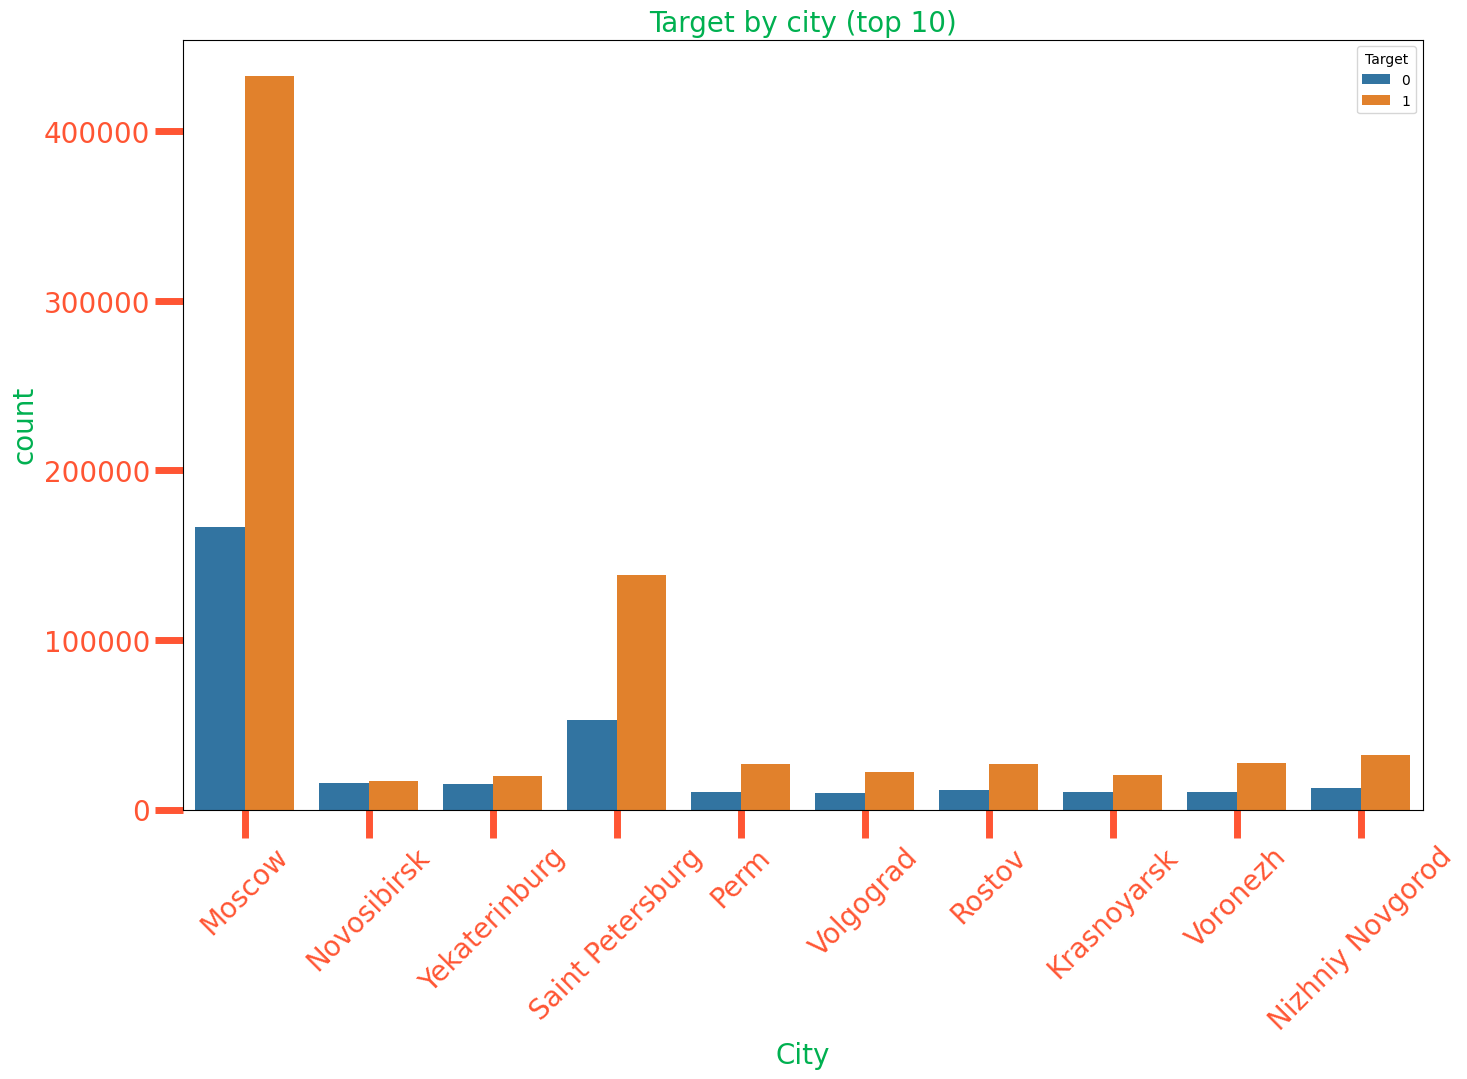

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

top_cities = data['city'].value_counts().nlargest(10).index

filtered_data = data[data['city'].isin(top_cities)]

plt.figure(figsize=(16, 10))
sns.countplot(x='city', hue='target', data=filtered_data)
plt.title('Target by city (top 10)')
plt.ylabel('count')
plt.xlabel('City')
plt.legend(title='Target', loc='upper right', labels=['0', '1'])
plt.xticks(rotation=45) 
plt.show()

In [32]:
data = data.drop('day_of_week', axis = 1)
data = data.drop('day', axis = 1)

In [33]:
data.head()

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,os,...,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,DistanceToCluster_15,DistanceToCluster_16,DistanceToCluster_17,DistanceToCluster_18,DistanceToCluster_19,text_length
0,2021-10-02 14:06:04,200,3146,0,1,34,Russia,Degtyarsk,3,Android,...,1.536087,3.070145,3.344350,3.297258,2.287106,4.180537,3.282031,3.238580,2.588535,140
1,2021-10-02 14:09:27,200,6635,1,1,34,Russia,Degtyarsk,3,Android,...,2.772576,1.647115,3.145356,2.207700,3.032217,3.749222,2.446134,2.281046,3.271626,483
2,2021-10-06 15:02:13,200,668,1,1,34,Russia,Degtyarsk,3,Android,...,2.968009,1.983850,2.724666,1.911275,3.046561,3.315398,2.119372,2.261013,2.697747,2581
3,2021-10-07 20:24:58,200,6578,1,1,34,Russia,Degtyarsk,3,Android,...,2.983869,1.745763,3.507599,2.327002,3.224195,3.872458,2.255754,2.134415,3.426278,717
4,2021-10-07 20:57:00,200,1474,1,1,34,Russia,Degtyarsk,3,Android,...,3.681416,3.471213,2.945859,3.440753,3.865437,3.365990,3.707081,3.952207,3.471257,1065


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3750000 entries, 0 to 3749999
Data columns (total 37 columns):
 #   Column                Dtype         
---  ------                -----         
 0   timestamp             datetime64[ns]
 1   user_id               int64         
 2   post_id               int64         
 3   target                int64         
 4   gender                int64         
 5   age                   int64         
 6   country               object        
 7   city                  object        
 8   exp_group             int64         
 9   os                    object        
 10  source                object        
 11  hour                  int64         
 12  month                 int64         
 13  post_likes            int64         
 14  topic                 object        
 15  TextCluster           int32         
 16  DistanceToCluster_0   float32       
 17  DistanceToCluster_1   float32       
 18  DistanceToCluster_2   float32       
 19  

In [ ]:
### Фильтрация признаков

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(data, 15))

In [36]:
### Удалим колонки, где корреляция оказывается > 0.9

def correlation(dataset, threshold):
    col_corr = set() 
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] 
    
correlation(data, 0.9)

In [41]:
### Кодирование категориальных переменных

for col in data.select_dtypes(include=['object']).columns:
    if data[col].nunique() < 3:
        one_hot = pd.get_dummies(data[col], drop_first=True, prefix = col)
        data = pd.concat((data.drop(col, axis=1), one_hot), axis=1)
    else:
        mean_target = data.groupby(col)['target'].mean()
        data[col] = data[col].map(mean_target)

In [42]:
### Преобразуем размер

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = data[numeric_columns].astype('float32')

In [43]:
data.head()

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,hour,...,DistanceToCluster_5,DistanceToCluster_7,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_13,DistanceToCluster_16,text_length,os_iOS,source_organic
0,2021-10-02 14:06:04,200.0,3146.0,0.0,1.0,34.0,0.653378,0.675799,3.0,14.0,...,2.380875,3.356188,3.002289,3.086170,3.854152,3.344350,4.180537,140.0,0,0
1,2021-10-02 14:09:27,200.0,6635.0,1.0,1.0,34.0,0.653378,0.675799,3.0,14.0,...,2.785335,2.342622,3.338968,3.471609,3.521826,3.145356,3.749222,483.0,0,0
2,2021-10-06 15:02:13,200.0,668.0,1.0,1.0,34.0,0.653378,0.675799,3.0,15.0,...,2.975629,1.813258,2.591090,2.832570,3.047662,2.724666,3.315398,2581.0,0,0
3,2021-10-07 20:24:58,200.0,6578.0,1.0,1.0,34.0,0.653378,0.675799,3.0,20.0,...,2.903379,2.354270,3.431001,3.703350,3.771147,3.507599,3.872458,717.0,0,0
4,2021-10-07 20:57:00,200.0,1474.0,1.0,1.0,34.0,0.653378,0.675799,3.0,20.0,...,3.667401,3.461104,3.315893,3.181571,1.325194,2.945859,3.365990,1065.0,0,0


In [39]:
max(data.timestamp), min(data.timestamp)

(Timestamp('2021-12-29 23:48:26'), Timestamp('2021-10-01 06:01:40'))

In [44]:
from sklearn.preprocessing import StandardScaler

### За отсечку возьмем 2021-12-15

df_train = data[data.timestamp < '2021-12-15']
df_test = data[data.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((3062845,), (687155,))

In [ ]:
data = data.drop('timestamp', axis=1)

In [45]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier()
catboost_model = catboost_model.fit(X_train, y_train)

Learning rate set to 0.317329
0:	learn: 0.6360383	total: 363ms	remaining: 6m 2s
1:	learn: 0.6152616	total: 566ms	remaining: 4m 42s
2:	learn: 0.5975068	total: 837ms	remaining: 4m 38s
3:	learn: 0.5874659	total: 1.12s	remaining: 4m 39s
4:	learn: 0.5837094	total: 1.35s	remaining: 4m 29s
5:	learn: 0.5815641	total: 1.56s	remaining: 4m 18s
6:	learn: 0.5784137	total: 1.83s	remaining: 4m 20s
7:	learn: 0.5774815	total: 2.08s	remaining: 4m 17s
8:	learn: 0.5749893	total: 2.31s	remaining: 4m 14s
9:	learn: 0.5744325	total: 2.53s	remaining: 4m 10s
10:	learn: 0.5732589	total: 2.78s	remaining: 4m 10s
11:	learn: 0.5729619	total: 3.01s	remaining: 4m 8s
12:	learn: 0.5716766	total: 3.32s	remaining: 4m 12s
13:	learn: 0.5703741	total: 3.57s	remaining: 4m 11s
14:	learn: 0.5701070	total: 3.79s	remaining: 4m 9s
15:	learn: 0.5695302	total: 4.02s	remaining: 4m 7s
16:	learn: 0.5691311	total: 4.24s	remaining: 4m 5s
17:	learn: 0.5687002	total: 4.51s	remaining: 4m 6s
18:	learn: 0.5685384	total: 4.72s	remaining: 4m 3s

In [46]:
### Замерим качество работы
from sklearn.metrics import roc_auc_score

print(f"Train quality: {roc_auc_score(y_train, catboost_model.predict_proba(X_train)[:, 1])}")
print(f"Test quality: {roc_auc_score(y_test, catboost_model.predict_proba(X_test)[:, 1])}")

Train quality: 0.7154238802119399
Test quality: 0.6721215313225951


In [47]:
### Сохранение модели
catboost_model.save_model('model_control', format="cbm") 

In [48]:
data.to_csv('data_control')